In [1]:
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from data_preprocessing import load_X_y
import pandas as pd

weather_df, pollutant_df = load_X_y()
weather_df_normalized = (weather_df-weather_df.min())/(weather_df.max()-weather_df.min())

pollutant_tensor = torch.tensor(pollutant_df['P2.5'].values)
weather_tensor = torch.tensor(weather_df_normalized[:].values)

# Making PyTorch Dataset Object

In [3]:
from torch.utils.data import Dataset

# creating a custom dataset in a sliding window manner
class WeatherPollutantDataset(Dataset):
    def __init__(self, weather: torch.Tensor, pollutant: torch.Tensor, window:int):
        self.weather = weather
        self.pollutant = pollutant
        # assumes the data starts on the same day
        # assumes their length is the same
        assert len(self.weather) == len(self.pollutant)
        self.window = window

    def __getitem__(self, index: int):
        """
        Using weather input on day i,i+1,...,i+window-1 to predict pollutant output on i+window
        """
        weather_input = self.weather[index:index+self.window].permute(1,0)
        pollutant_output = self.pollutant[index+self.window]
        return weather_input, pollutant_output

    def __len__(self):
        return len(self.weather) - self.window

In [4]:
train_set = WeatherPollutantDataset(weather=weather_tensor[:5014], pollutant=pollutant_tensor[:5014], window=14)
val_set   = WeatherPollutantDataset(weather=weather_tensor[5014:6028], pollutant=pollutant_tensor[5014:6028], window=14)
test_set  = WeatherPollutantDataset(weather=weather_tensor[6028:7042], pollutant=pollutant_tensor[6028:7042], window=14)

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=len(train_set))
train_X, train_y = next(iter(train_loader))

# Converting PyTorch to Numpy
- Pytorch tensor is changed to numpy array
- train_X is (5000 number of inputs, 168 number of features 14days*12features), train_y is (5000,)

In [6]:
train_X = train_X.numpy()
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1]*train_X.shape[2])
train_y = train_y.numpy()

print(train_X.shape)
print(train_y.shape)

(5000, 168)
(5000,)


# Training of Random Forest

In [16]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth=4)
rf.fit(train_X, train_y)

RandomForestRegressor(max_depth=4, random_state=42)

# Make Prediction
- Test around hyperparameters on validation set above
- Get final test loss using test set above

# Validation

In [17]:
val_loader = DataLoader(val_set, batch_size=len(val_set))
val_X, val_y = next(iter(val_loader))
val_X = val_X.reshape(val_X.shape[0], val_X.shape[1]*val_X.shape[2])
pred = rf.predict(val_X)

metrics.mean_squared_error(pred, val_y)

40.69661080155391

# Testing

In [19]:
test_loader = DataLoader(test_set, batch_size=len(test_set))
test_X, test_y = next(iter(test_loader))
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1]*test_X.shape[2])
pred = rf.predict(test_X)

metrics.mean_squared_error(pred, test_y)

52.50712480154146

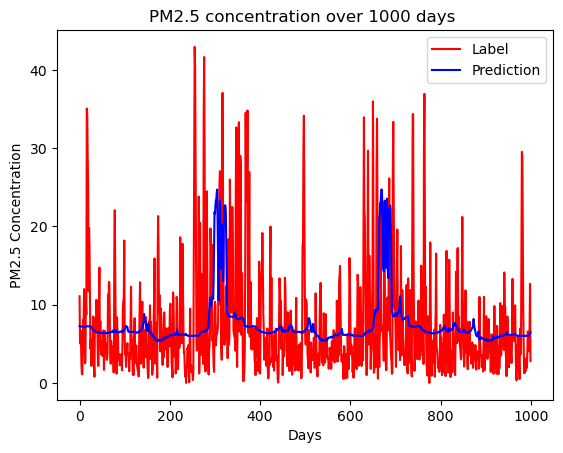

In [20]:
import matplotlib.pyplot as plt

t = range(1000)
plt.title("PM2.5 concentration over 1000 days ")
plt.plot(t, test_y, 'r', label="Label")
plt.plot(t, pred, 'b', label='Prediction')
plt.xlabel("Days")
plt.ylabel("PM2.5 Concentration")
plt.legend(loc='best')
plt.show()